In [2]:
import torch
import timm
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image
import numpy as np
import umap
import matplotlib.pyplot as plt

e:\code\DSCI-592\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


True
12.1


In [3]:
# Load DINOv2 ViT-small (pretrained)
dino_model = timm.create_model('vit_small_patch16_224.dino', pretrained=True)
dino_model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dino_model = dino_model.to(device)

print("Model loaded and moved to device:", device)

Model loaded and moved to device: cuda


In [4]:
print("Model loaded and moved to device:", device)

Model loaded and moved to device: cuda


In [5]:
from tqdm import tqdm
# Transformation for DINOv2

# Faster DINOv2 Transformation without PIL
dino_transform = transforms.Compose([
    transforms.ToTensor(),  # Direct from numpy (uint8) to tensor [0,1]
    transforms.Resize((224, 224), antialias=True),
    transforms.ConvertImageDtype(torch.float32),  # Ensure float32
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


# Feature extraction function
def extract_features_dino(images_np, batch_size=128):
    features = []
    num_images = len(images_np)
    
    for i in tqdm(range(0, num_images, batch_size), desc="Extracting features"):
        batch_images = images_np[i:i+batch_size]
        batch_tensors = []

        for img_np in batch_images:
            img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)
            img_tensor = img_tensor.float() / 255.0  # Scale 0-1
            img_tensor = torch.nn.functional.interpolate(img_tensor.unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False)
            img_tensor = img_tensor.squeeze(0)
            img_tensor = (img_tensor - 0.5) / 0.5  # Normalize to mean=0, std=1
            batch_tensors.append(img_tensor)

        batch_tensors = torch.stack(batch_tensors).to(device)  # (batch_size, 3, 224, 224)

        with torch.no_grad():
            feats = dino_model.forward_features(batch_tensors)[:, 0]  # Take only CLS token

        features.append(feats.cpu().numpy())

    features = np.concatenate(features, axis=0)
    return features



In [8]:
import cv2
import os
import numpy as np

def load_images_cv2(folder_path, resize_shape=(32, 32)):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)  # BGR format
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, resize_shape)
            image_list.append(img)
    return np.array(image_list)

# Usage
images_folder = 'data/output/png/'
images_np = load_images_cv2(images_folder, resize_shape=(32, 32))

print(f"✅ Loaded {len(images_np)} images, shape: {images_np.shape}")


✅ Loaded 9834 images, shape: (9834, 32, 32, 3)


In [9]:
features = extract_features_dino(images_np)
print(features.shape)  # Should be (num_images, 384)


Extracting features: 100%|██████████| 77/77 [00:11<00:00,  6.56it/s]

(9834, 384)


In [10]:
# Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings = reducer.fit_transform(features)

print(embeddings.shape)  # (num_images, 2)


e:\code\DSCI-592\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
e:\code\DSCI-592\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(9834, 2)


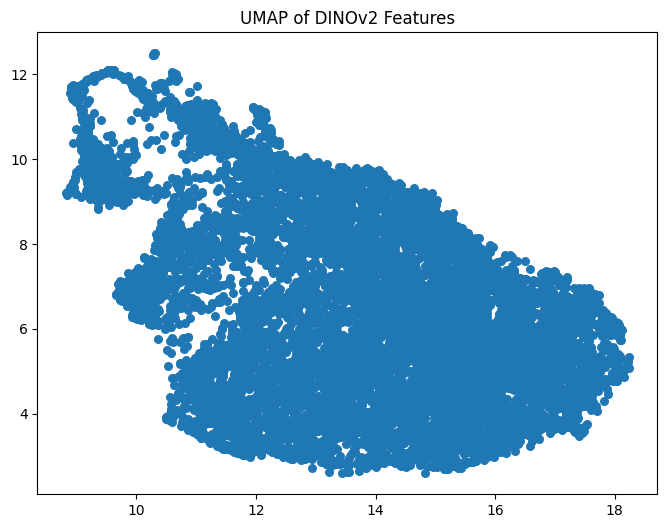

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(embeddings[:,0], embeddings[:,1], s=30)
plt.title('UMAP of DINOv2 Features')
plt.show()

In [12]:
import torch

# Script the DINOv2 feature extractor
class DinoFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(DinoFeatureExtractor, self).__init__()
        self.backbone = model

    def forward(self, x):
        x = self.backbone.forward_features(x)  # Get all tokens
        x = x[:, 0]  # Take only CLS token
        return x  # Output shape (batch_size, 384)

# Wrap the model
feature_extractor = DinoFeatureExtractor(dino_model).to('cpu')  # Move to CPU for scripting

# Save as TorchScript
scripted_model = torch.jit.script(feature_extractor)
os.makedirs("dino_model/1", exist_ok=True)
scripted_model.save("dino_model/1/model.pt")

print("✅ Saved model to dino_model/1/model.pt")


✅ Saved model to dino_model/1/model.pt


In [13]:
loaded_model = torch.jit.load("dino_model/1/model.pt")
loaded_model.eval()

# Dummy input (batch of 2 images)
dummy_input = torch.randn(2, 3, 224, 224)  # Random normalized images
output = loaded_model(dummy_input)

print(output.shape)  # Should be (2, 384)
print(output)

torch.Size([2, 384])
tensor([[-8.0494e-02,  4.2333e+00,  2.6401e+00,  2.7728e+00,  4.4755e+00,
          2.9464e-01,  3.2885e+00, -5.4653e+00, -2.8222e-01, -6.5726e-01,
          2.9766e+00,  1.6644e+00, -7.7508e-01,  4.5088e+00,  3.9345e+00,
         -2.0250e+00, -9.2100e-01,  3.5532e+00, -7.4414e-01,  5.1173e+00,
          4.9675e+00,  1.8588e+00, -2.3327e+00,  4.0415e-01,  7.1153e+00,
         -8.6158e+00,  2.4108e+00,  8.2962e+00,  6.2658e-01, -4.4591e-01,
         -9.8159e+00, -6.7530e-01,  3.4200e+00, -1.3331e+00,  3.9769e-01,
          1.6992e+00,  3.7959e+00, -1.5781e+00, -6.1048e+00,  5.3857e+00,
          2.6676e+00,  5.0654e+00, -4.9477e+00,  1.5052e+00,  2.0999e+00,
         -2.6899e+00, -1.8704e+00, -1.5505e+00,  1.1187e+01, -4.4405e+00,
         -5.2054e+00,  2.5869e+00, -2.9847e+00, -2.6168e+00,  8.2455e-01,
         -1.2555e+00,  1.6295e+00,  1.0179e+01, -9.1067e-01, -2.8036e+00,
          2.1551e+00, -1.8730e+00, -1.2411e+00, -4.6292e+00, -1.6360e+00,
          5.4153e

In [14]:
print(loaded_model.graph)

graph(%self.1 : __torch__.DinoFeatureExtractor,
      %x.1 : Tensor):
  %9 : NoneType = prim::Constant()
  %13 : int = prim::Constant[value=1]() # C:\Users\Chirayu\AppData\Local\Temp\ipykernel_29556\3552681436.py:11:12
  %14 : int = prim::Constant[value=0]() # C:\Users\Chirayu\AppData\Local\Temp\ipykernel_29556\3552681436.py:11:17
  %backbone.1 : __torch__.timm.models.vision_transformer.VisionTransformer = prim::GetAttr[name="backbone"](%self.1)
  %x0.1 : Tensor = prim::CallMethod[name="forward_features"](%backbone.1, %x.1) # C:\Users\Chirayu\AppData\Local\Temp\ipykernel_29556\3552681436.py:10:12
  %12 : Tensor = aten::slice(%x0.1, %14, %9, %9, %13) # C:\Users\Chirayu\AppData\Local\Temp\ipykernel_29556\3552681436.py:11:12
  %15 : Tensor = aten::select(%12, %13, %14) # C:\Users\Chirayu\AppData\Local\Temp\ipykernel_29556\3552681436.py:11:12
  return (%15)



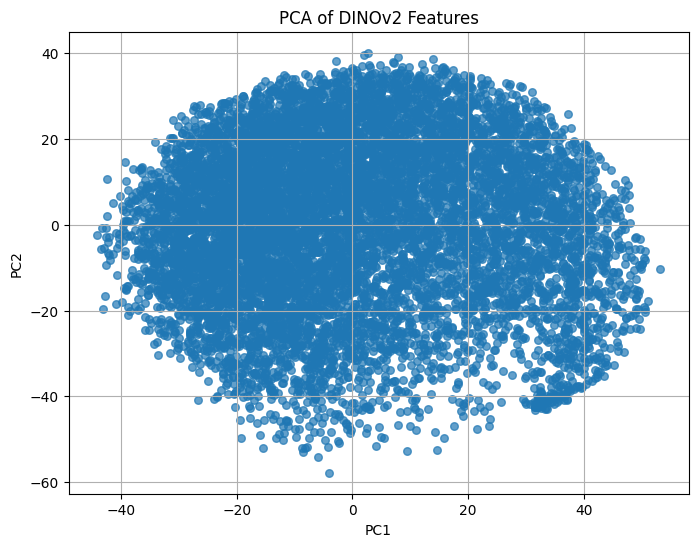

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], s=30, alpha=0.7)
plt.title("PCA of DINOv2 Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

e:\code\DSCI-592\venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
e:\code\DSCI-592\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "e:\code\DSCI-592\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Chirayu\.conda\envs\tf-gpu\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Chirayu\.conda\envs\tf-gpu\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, clo

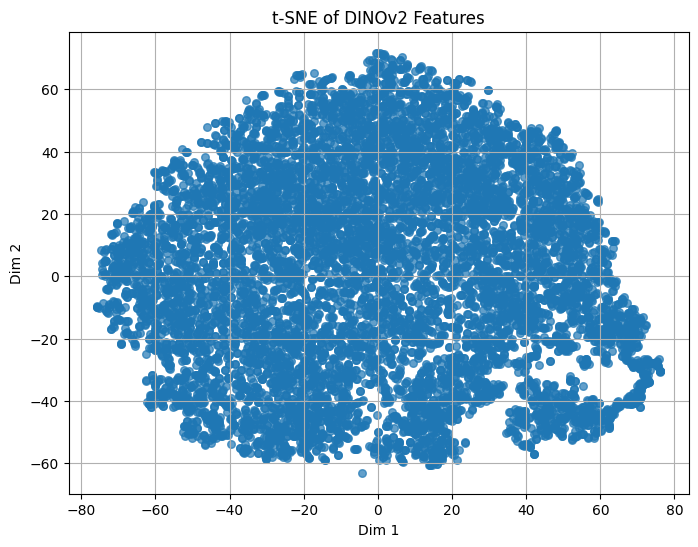

In [16]:
from sklearn.manifold import TSNE

# You can optionally reduce dimensions first with PCA for faster TSNE
features_pca_50 = PCA(n_components=50).fit_transform(features)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', n_iter=1000)
tsne_embeddings = tsne.fit_transform(features_pca_50)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=30, alpha=0.7)
plt.title("t-SNE of DINOv2 Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

In [20]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   -- ------------------------------------ 23.1/375.7 MB 122.0 MB/s eta 0:00:03
   ---- ---------------------------------- 47.4/375.7 MB 121.0 MB/s eta 0:00:03
   ------- ------------------------------- 72.9/375.7 MB 119.2 MB/s eta 0:00:03
   ---------- ---------------------------- 96.7/375.7 MB 118.8 MB/s eta 0:00:03
   ------------ ------------------------- 120.8/375.7 MB 117.0 MB/s eta 0:00:03
   -------------- ----------------------- 145.8/375.7 MB 116.4 MB/s eta 0:00:02
   ----------------- -------------------- 169.6/375.7 MB 116.5 MB/s eta 0:00:02
   ------------------- ------------------ 194.5/375.7 MB 117.3 MB/s eta 0:00:02
   ---------------------- --------------- 219.4/375.7 MB 116.9 MB/s eta 0:00:02
   ------------------------ ------------- 243.5/375.7 MB 117.1 MB/s eta 0:00:02
   --------------------------- ---------- 267.6/375.7 MB

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# Use the same GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [31]:
import tensorflow as tf
from umap.parametric_umap import ParametricUMAP


# Define a Keras model
input_layer = tf.keras.layers.Input(shape=(384,))
x = tf.keras.layers.Dense(256, activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(2)(x)

keras_encoder = tf.keras.Model(inputs=input_layer, outputs=output_layer)


In [32]:
# Enable GPU in TensorFlow
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 0


In [33]:
# Convert data
features_np = features.astype('float32')


In [34]:
# Fit Parametric UMAP
parametric_umap = ParametricUMAP(encoder=keras_encoder, n_components=2, n_epochs=100, verbose=True)
umap_nn_embeddings = parametric_umap.fit_transform(features_np)


e:\code\DSCI-592\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ParametricUMAP(encoder=<Functional name=functional, built=True>)
Thu May  1 16:25:36 2025 Construct fuzzy simplicial set
Thu May  1 16:25:36 2025 Finding Nearest Neighbors
Thu May  1 16:25:36 2025 Building RP forest with 10 trees
Thu May  1 16:25:36 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Thu May  1 16:25:37 2025 Finished Nearest Neighbor Search
Thu May  1 16:25:37 2025 Construct embedding
Epoch 1/10


e:\code\DSCI-592\venv\lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


653/653 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2923
Epoch 2/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2689
Epoch 3/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2656
Epoch 4/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2642
Epoch 5/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2632
Epoch 6/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2621
Epoch 7/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2617
Epoch 8/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2607
Epoch 9/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2601
Epoch 10/10
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2595
308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
Thu May  1 16:26:11 2025 Finished embedding


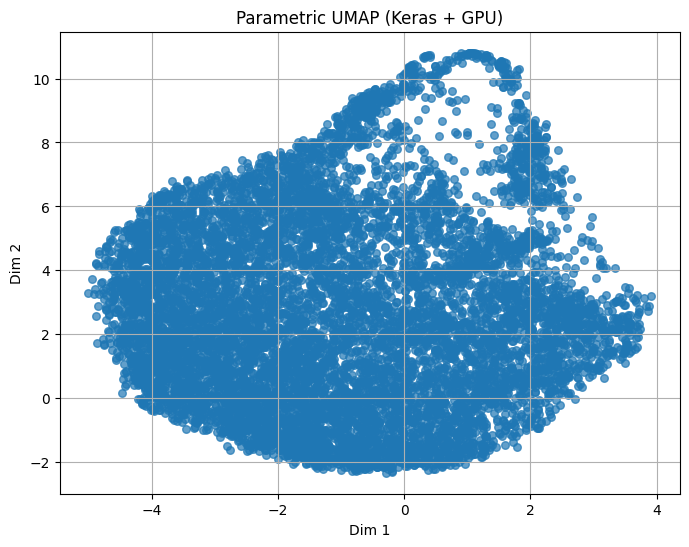

In [35]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(umap_nn_embeddings[:, 0], umap_nn_embeddings[:, 1], s=30, alpha=0.7)
plt.title("Parametric UMAP (Keras + GPU)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

In [36]:
from sklearn.manifold import TSNE
from torch.utils.data import TensorDataset, DataLoader



In [37]:
# Run t-SNE on original features (non-differentiable)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_target = tsne.fit_transform(features)


In [38]:
# Prepare training data
X_tensor = torch.tensor(features, dtype=torch.float32)
Y_tensor = torch.tensor(tsne_target, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [39]:
import torch.nn as nn

In [40]:
# Define simple MLP
tsne_net = nn.Sequential(
    nn.Linear(384, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
)

In [41]:
optimizer = torch.optim.Adam(tsne_net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [42]:
# Train the model to mimic t-SNE
for epoch in range(100):
    for x_batch, y_batch in dataloader:
        pred = tsne_net(x_batch)
        loss = loss_fn(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 138.4908
Epoch 10 | Loss: 147.7123
Epoch 20 | Loss: 83.9891
Epoch 30 | Loss: 45.7108
Epoch 40 | Loss: 46.6198
Epoch 50 | Loss: 45.3525
Epoch 60 | Loss: 37.9704
Epoch 70 | Loss: 36.5917
Epoch 80 | Loss: 30.2182
Epoch 90 | Loss: 27.0984


In [43]:
# Get embeddings from trained net
tsne_nn_embeddings = tsne_net(X_tensor).detach().numpy()


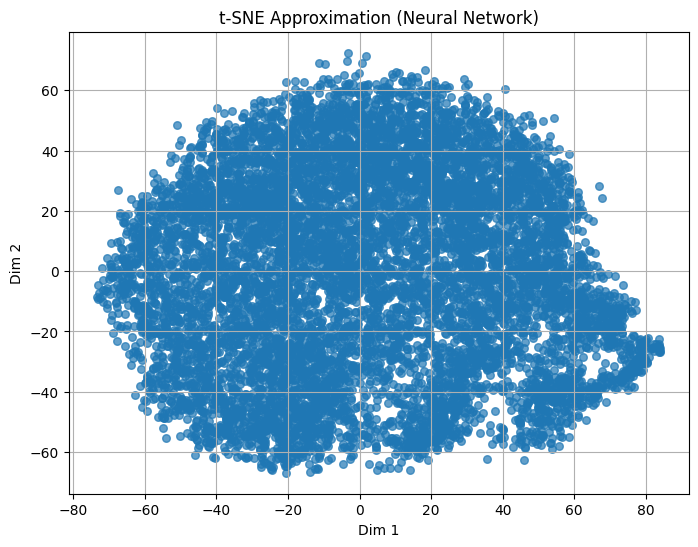

In [44]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_nn_embeddings[:, 0], tsne_nn_embeddings[:, 1], s=30, alpha=0.7)
plt.title("t-SNE Approximation (Neural Network)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()